# Bundle Heating Model
Lay out a rough plan for our "bundle" heating model in which nanoflare storms occur on a bundle of strands.

In [765]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.sun import constants
import synthesizAR
from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

In [2]:
noaa1158 = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [34]:
magnetogram = (sunpy.map.Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/hmi/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits')
               .rotate()
               .submap(noaa1158.magnetogram.bottom_left_coord, noaa1158.magnetogram.top_right_coord))

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


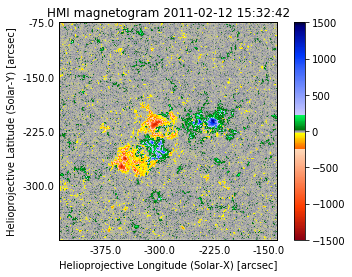

In [586]:
magnetogram.peek(vmin=-1.5e3,vmax=1.5e3,cmap='hmimag')
plt.show()

In [280]:
fp_x=[]
fp_y=[]
for l in noaa1158.loops[::]:
    loop_hpc = (heeq_to_hcc_coord(l.coordinates[:,0], l.coordinates[:,1], l.coordinates[:,2],
                                  magnetogram.observer_coordinate)
                .transform_to(magnetogram.coordinate_frame))
    fp_x.append(loop_hpc[0].Tx.to(u.arcsec).value)
    fp_y.append(loop_hpc[0].Ty.to(u.arcsec).value)

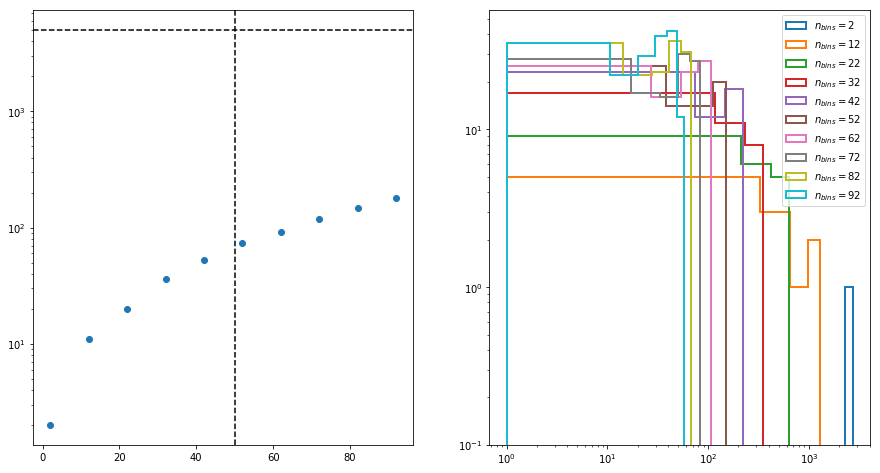

In [281]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
for i,nbins in enumerate(np.arange(2,100,10)):
    pop,_,_ = np.histogram2d(fp_x, fp_y, bins=(nbins, nbins),
                             range=((magnetogram.bottom_left_coord.Tx.to(u.arcsec).value, magnetogram.top_right_coord.Tx.to(u.arcsec).value),
                                    (magnetogram.bottom_left_coord.Ty.to(u.arcsec).value, magnetogram.top_right_coord.Ty.to(u.arcsec).value)))
    axes[0].plot(nbins,np.where(pop != 0.)[0].shape,color='C0',marker='o', ls='')
    filled_bins = pop[np.where(pop != 0.)]
    axes[1].hist(filled_bins, bins='fd',color=f'C{i}',histtype='step',lw=2,log=True,label=f'$n_{{bins}}={nbins}$')
axes[0].axhline(y=5000,ls='--',color='k')
axes[0].axvline(x=50,ls='--',color='k')
axes[1].set_xscale('log')
axes[0].set_yscale('log')
axes[1].legend()

In [574]:
# Bin footpoints
n_bundles_x, n_bundles_y = 50,50
pop, bin_edges_x, bin_edges_y = np.histogram2d(fp_x, fp_y,
                                               bins=(n_bundles_x, n_bundles_y),
                                               range=((magnetogram.bottom_left_coord.Tx.to(u.arcsec).value, magnetogram.top_right_coord.Tx.to(u.arcsec).value),
                                                      (magnetogram.bottom_left_coord.Ty.to(u.arcsec).value, magnetogram.top_right_coord.Ty.to(u.arcsec).value)))
bundle_index = np.stack([np.digitize(fp_x, bin_edges_x), np.digitize(fp_y, bin_edges_y)], axis=1)

In [590]:
class Bundle(object):
    def __init__(self, loops, grid_x, grid_y):
        self.loops = loops
        self.grid_pos = (grid_x, grid_y)
        
    @property
    def average_field_strength(self):
        return np.array([l.field_strength.mean().to(u.Gauss).value for l in self.loops]).sum() / len(self.loops) * u.Gauss
    
    @property
    def total_flux(self):
        return np.array([(l.field_strength.mean().to(u.G)**2 * l.full_length.to(u.cm)).value / (8. * np.pi) for l in self.loops]).sum() * u.erg / (u.cm**2)
   

In [576]:
bundles = []
loop_array = np.array(noaa1158.loops)
for pos_x, pos_y in np.stack(np.where(pop != 0),axis=1):
    loop_indices, = np.where(np.logical_and(bundle_index[:,0]-1 == pos_x,
                                            bundle_index[:,1]-1 == pos_y))
    bundles.append(Bundle(loop_array[loop_indices].tolist(), pos_x, pos_y))

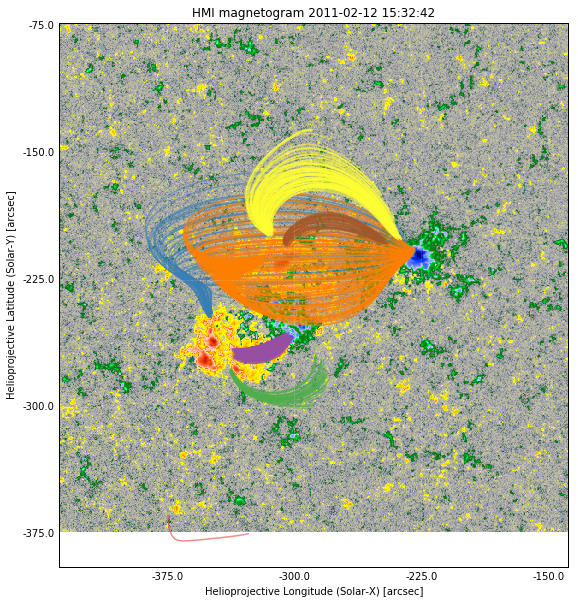

In [398]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=magnetogram)
magnetogram.plot(axes=ax,
                 cmap='hmimag',
                 vmin=-1.5e3,
                 vmax=1.5e3)
# Draw loops
colors = sns.color_palette('Set1', len(bundles[::10]))
for i,b in enumerate(bundles[::10]):
    for l in b.loops:
        loop_hpc = (heeq_to_hcc_coord(l.coordinates[:,0],
                                      l.coordinates[:,1],
                                      l.coordinates[:,2],
                                      magnetogram.observer_coordinate)
                    .transform_to(magnetogram.coordinate_frame))
        ax.plot_coord(loop_hpc, color=colors[i],alpha=0.5)

In [577]:
total_average_field = 0. * u.Gauss
for b in bundles:
    total_average_field += b.average_field_strength
storm_distribution = np.random.choice(len(bundles),
                                      size=5000,
                                      replace=True,
                                      p=[(b.average_field_strength / total_average_field).value for b in bundles])

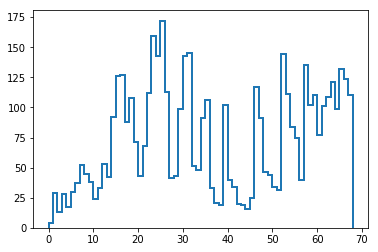

In [578]:
nstorms_per_bundle,edges,_ = plt.hist(storm_distribution,
                                      histtype='step', lw=2, bins=np.arange(len(bundles)+1))

In [581]:
total_flux = 0. * u.erg / (u.cm**2)
stress = 0.1
for nsb,b in zip(nstorms_per_bundle, bundles):
    total_flux += (stress**2) * b.total_flux

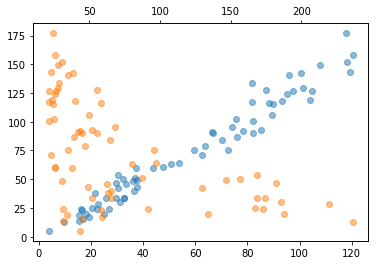

In [572]:
fig = plt.figure()
ax = fig.gca()
ax.plot([b.average_field_strength.value for b in bundles], nstorms_per_bundle,'o',ls='',alpha=0.5)
average_loop_length = []
for b in bundles:
    average_loop_length.append(np.array([l.full_length.to(u.Mm).value for l in b.loops]).mean())
ax2 = ax.twiny()
ax2.plot(average_loop_length, nstorms_per_bundle,'o',ls='',color='C1',alpha=0.5)

## Model Description

First, we need to create the bundles. As a first pass, we do this by dividing the magnetosphere into $n_xn_y$ boxes of equal area. If the $B<0$ footpoint falls in box $b$, it is part of bundle $b$. Presumably, we could come up with some more sophisticated method for defining a "bundle," but this will do for now.

Boxes with 0 loop footpoints in them are ignored. 

In [ ]:
class Bundle(object):
    def __init__(self, loops, grid_x, grid_y):
        self.loops = loops
        self.grid_pos = (grid_x, grid_y)
        
    @property
    def average_field_strength(self):
        return np.array([l.field_strength.mean().to(u.Gauss).value for l in self.loops]).sum() / len(self.loops) * u.Gauss
    
    @property
    def total_flux(self):
        return np.array([(l.field_strength.mean().to(u.G)**2 * l.full_length.to(u.cm)).value / (8. * np.pi) for l in self.loops]).sum() * u.erg / (u.cm**2)
   

In [633]:
n_bundles_x, n_bundles_y = 50,50
pop, bin_edges_x, bin_edges_y = np.histogram2d(fp_x, fp_y,
                                               bins=(n_bundles_x, n_bundles_y),
                                               range=((magnetogram.bottom_left_coord.Tx.to(u.arcsec).value, magnetogram.top_right_coord.Tx.to(u.arcsec).value),
                                                      (magnetogram.bottom_left_coord.Ty.to(u.arcsec).value, magnetogram.top_right_coord.Ty.to(u.arcsec).value)))
bundle_index = np.stack([np.digitize(fp_x, bin_edges_x), np.digitize(fp_y, bin_edges_y)], axis=1)
bundles = []
loop_array = np.array(noaa1158.loops)
for pos_x, pos_y in np.stack(np.where(pop != 0),axis=1):
    loop_indices, = np.where(np.logical_and(
        bundle_index[:,0]-1 == pos_x,bundle_index[:,1]-1 == pos_y))
    bundles.append(Bundle(loop_array[loop_indices].tolist(), pos_x, pos_y))

In [799]:
loop_indices

array([  14,  168,  276,  448,  527,  645,  742,  872,  965, 1139, 1232,
       1265, 1283, 1462, 1463, 1571, 1600, 1613, 1628, 1653, 1837, 1955,
       1992, 2152, 2154, 2226, 2282, 2294, 2382, 2414, 2516, 2632, 2660,
       2674, 2753, 2980, 2988, 3030, 3188, 3190, 3211, 3220, 3303, 3391,
       3448, 3522, 3696, 3743, 3770, 3810, 3874, 3942, 4193, 4209, 4280,
       4282, 4297, 4439, 4596, 4680, 4828, 4853, 4895])

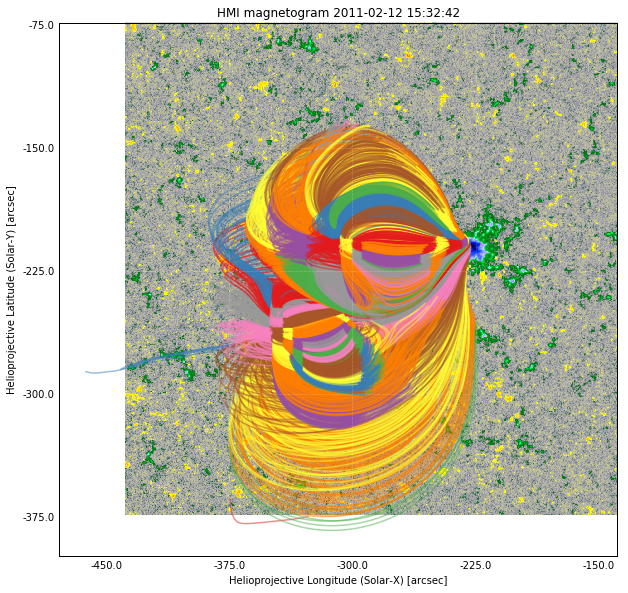

In [637]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=magnetogram)
magnetogram.plot(axes=ax,
                 cmap='hmimag',
                 vmin=-1.5e3,
                 vmax=1.5e3)
# Draw loops
colors = sns.color_palette('Set1', len(bundles))
for i,b in enumerate(bundles):
    for l in b.loops:
        loop_hpc = (heeq_to_hcc_coord(l.coordinates[:,0],
                                      l.coordinates[:,1],
                                      l.coordinates[:,2],
                                      magnetogram.observer_coordinate)
                    .transform_to(magnetogram.coordinate_frame))
        ax.plot_coord(loop_hpc, color=colors[i],alpha=0.5)

Next, we select $N_{storms}$ times from a uniform distribution $\mathcal{U}(0, t_{total})$ 

In [748]:
n_storms = 1000
time_total = 3e4*u.s
storm_times = np.random.uniform(low=0, high=3e4, size=n_storms)

For each of the times selected, we assign it to a particular bundle $b$ based on the probability,

$$
P_b = \frac{B_b}{\sum_b B_b},\quad\text{where}\quad B_b = \frac{\sum_l B_l}{N_b^{loops}},
$$

i.e. the probability of a storm occuring on a particular bundle $b$ is proportional to $B_b$, the average field strength of the loops in bundle $b$.

In [749]:
total_average_field = 0. * u.Gauss
for b in bundles:
    total_average_field += b.average_field_strength
p_b = [(b.average_field_strength / total_average_field).value for b in bundles]
storm_distribution = np.random.choice(len(bundles), size=n_storms, replace=True, p=p_b)
nstorms_per_bundle,_ = np.histogram(storm_distribution, bins=np.arange(len(bundles)+1))

In [809]:
np.all((np.bincount(storm_distribution) == nstorms_per_bundle))

True

In [813]:
len(bundles)
#nstorms_per_bundle.shape

68

In [814]:
np.bincount(np.array([1,1,1,1,1]),minlength=5)

array([0, 5, 0, 0, 0])

In [853]:
foo = np.random.rand(100)

In [857]:
foo[np.array([])]

IndexError: arrays used as indices must be of integer (or boolean) type

In [856]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [750]:
for i,b in enumerate(bundles):
    storm_time_indices, = np.where(storm_distribution == i)
    if storm_time_indices.shape[0] == 0:
        b.storm_start_times = np.array([])
    else:
        b.storm_start_times = np.sort(storm_times[storm_time_indices])
        # Assume that an event ended at t=0 s
        b.storm_delay_times = np.diff(np.hstack([0., b.storm_start_times]))

Now, to find the flux into bundle $b$ for each storm $s$, we adopt the physical picture that the flux is proportional to the time prior to storm $s$, $\Delta t_{sb}$, such that,

$$
F_{sb} \propto \Delta t_{sb},
$$

such that in cases where the field is stressed for longer periods of time there will be a larger energy release. Note that this qualitative picture could be reversed: the larger the energy release, the longer the field needs to become stressed again. We could choose to adopt either picture, though we will prefer the former (for now).

On a given bundle $b$, we place the following constraint on the total energy released over all storms,

$$
F_b = \sum_s F_{sb} = N_b^{storms} \epsilon^2\sum_l \frac{B_l^2 L_l}{8\pi}.
$$

such that the energy that goes into heating the plasma is some small fraction $\epsilon$ of the total energy density of the $b$.

From this, we can determine $F_{sb}$,

$$
F_b = \sum_s F_{sb} = \sum_s A_b \Delta t_{sb} = A_b \sum_s \Delta t_{sb} \\
A_b = \frac{F_b}{\sum_s \Delta t_{sb}} \\
F_{sb} = \frac{F_b}{\sum_s \Delta t_{sb}} \Delta t_{sb} = \left(N_b^{storms} \epsilon^2\sum_l \frac{B_l^2 L_l}{8\pi}\right)\frac{\Delta t_{sb}}{\sum_s \Delta t_{sb}}
$$

So now we can determine the total number of storms over all bundles, $N_{storms}$ by requiring that,

$$
|F - F^*| < \delta F^*
$$

where $\delta\ll1$ (typically $\delta\sim0.01$) and,

$$
F = \sum_bF_b = \sum_b N_b^{storms} \epsilon^2\sum_l \frac{B_l^2 L_l}{8\pi}, \\
F^* = Pt_{total}
$$

where $P$ (in erg cm$^{-2}$ s$^{-1}$) is some observed value of the flux (per unit time) over the whole active region. One example could be $P=10^7$ erg cm$^{-2}$ s$^{-1}$ from [Withbroe and Noyes (1978)](http://adsabs.harvard.edu/abs/1977ARA%26A..15..363W). This gives us an observational constraint and ensures that, for a fixed total simulation time, we are dumping in the same amount of energy into our active region.

Note that the parameter $\epsilon$ controls how much energy is dumped into each bundle such that lower $\epsilon$ allows for higher $N_{storms}$ (and *vice-versa*) such that there is a degeneracy in our selection of $\epsilon$ (or equivalently $N_{storms}$). 

In [751]:
flux_total = 0 * u.erg / (u.cm**2)
epsilon = 1e-2
for b,nb in zip(bundles,nstorms_per_bundle):
    flux_total += nb * epsilon**2 * np.array([l.field_strength.value.mean()**2 * l.full_length.to(u.cm).value / (8.*np.pi) for l in b.loops]).sum() * u.erg / (u.cm**2)

In [752]:
flux_total

<Quantity 8211504074268.708 erg / cm2>

In [753]:
P_observed = 1e7 * u.erg / u.cm**2 / u.s

In [754]:
flux_star = P_observed * time_total

In [766]:
print(np.fabs(flux_total - flux_star)/flux_star)

26.37168024756236


In [829]:
apex

5

In [842]:
i_top50

array([], dtype=int64)

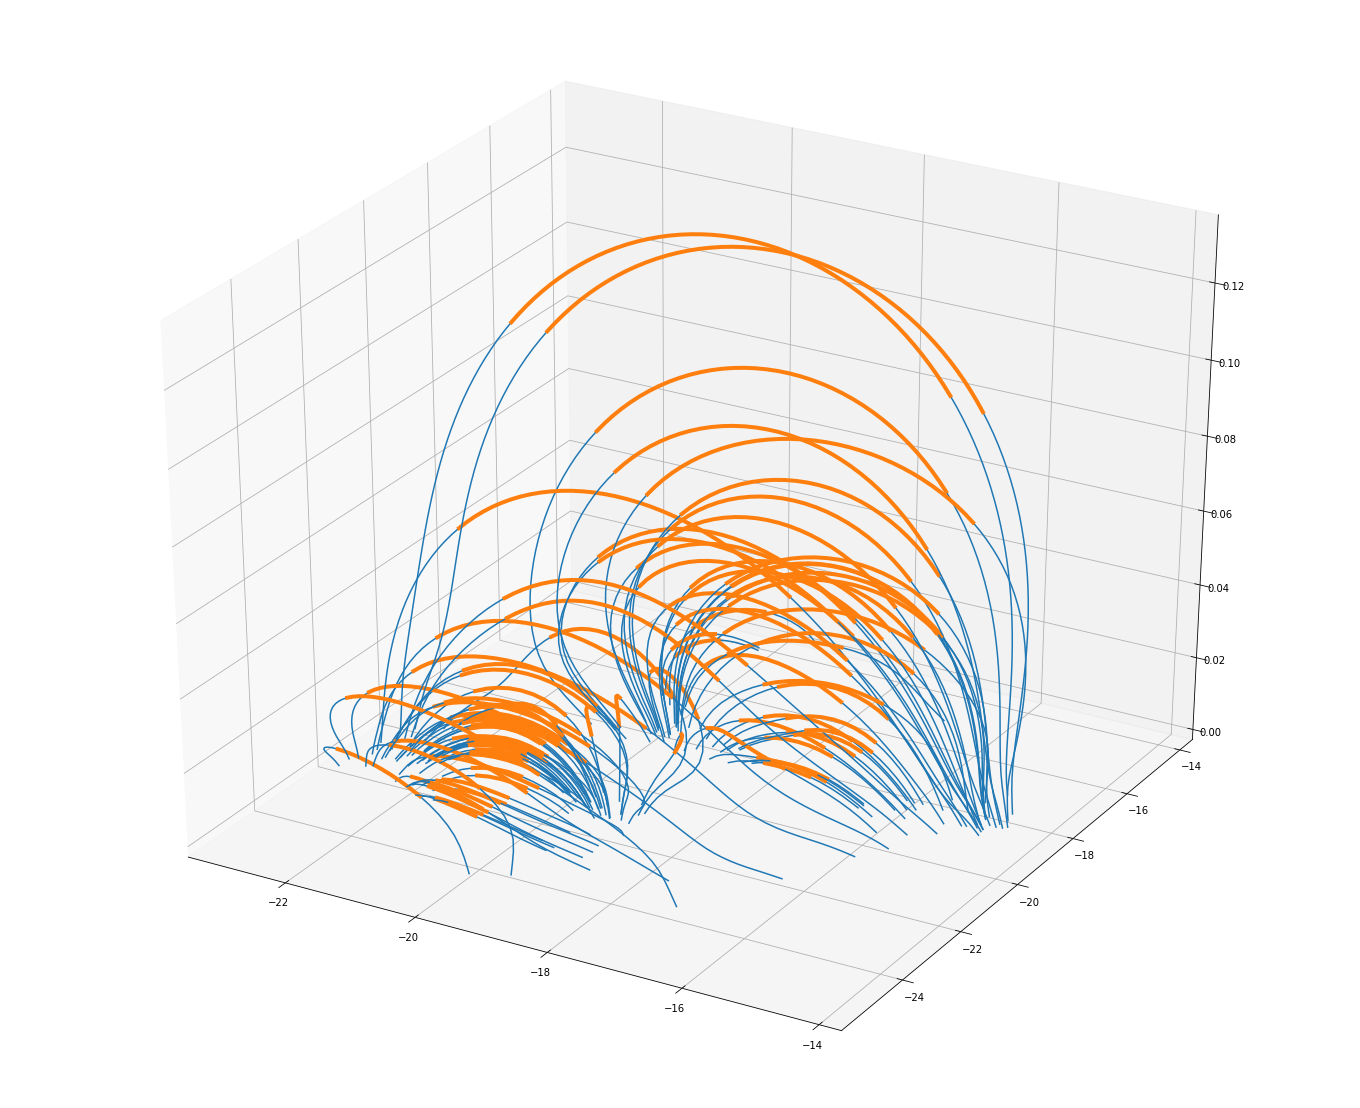

In [861]:
fig = plt.figure(figsize=(24,20))
ax = fig.gca(projection='3d')
for loop in noaa1158.loops[::50]:
    hgs_coord = heeq_to_hcc_coord(*loop.coordinates.T, noaa1158.magnetogram.observer_coordinate).transform_to('heliographic_stonyhurst')
    apex = np.argmax(hgs_coord.radius)
    ax.plot(hgs_coord.lon, hgs_coord.lat, (hgs_coord.radius - constants.radius).to(u.cm)/constants.radius.to(u.cm),color='C0')
    quarter_loop = 0.2 * loop.full_length
    s_apex = loop.field_aligned_coordinate[np.argmax(hgs_coord.radius)]
    i_top50, = np.where(np.logical_and(
        loop.field_aligned_coordinate.to(u.cm) >= s_apex - quarter_loop.to(u.cm),
        loop.field_aligned_coordinate.to(u.cm) <= s_apex + quarter_loop.to(u.cm)))
    ax.plot(hgs_coord.lon[i_top50], hgs_coord.lat[i_top50], 
            ((hgs_coord.radius - constants.radius).to(u.cm)/constants.radius.to(u.cm))[i_top50],
            color='C1',lw=4,alpha=1.)
    #ax.plot(hgs_coord.lon[[apex]],
    #        hgs_coord.lat[[apex]],
    #        ((hgs_coord.radius - constants.radius).to(u.cm)/constants.radius.to(u.cm))[[apex]],
    #        color='C2', marker='o', ls='', markersize=15)


In [800]:
loop_sublist = [noaa1158.loops[10], noaa1158.loops[15], noaa1158.loops[1000], noaa1158.loops[0]]

In [803]:
loop_sublist.index(noaa1158.loops[15])

1

In [821]:
np.diff(np.insert(u.Quantity([1,2,3],'s'),0,0*u.s))

<Quantity [ 1., 1., 1.] s>

In [822]:
u.Quantity(0,'erg / (cm2 s)')

<Quantity 0.0 erg / (cm2 s)>

In [827]:
foo = []
foo[0]

IndexError: list index out of range

In [852]:
np.random.uniform(low=0.*u.s, high=3e4*u.s)

TypeError: only dimensionless scalar quantities can be converted to Python scalars